# Differentiable ZNE: Error-mitigated VQE

At this point, you've been exposed to modelling noise in a quantum circuit and how to amplify a circuit's noise via global circuit folding. In this challenge, you will pioneer a way to perform an error-mitigated version of a quintessential quantum algorithm on noisy hardware!

The variational quantum eigensolver (VQE) algorithm is an elegant optimization algorithm that estimates the ground state and ground state energy of a Hamiltonian. The Hamiltonian could describe anything, so long as there's an efficient map to mapping the degrees of freedom to binary variables. Here, we'll use the qubit representation of the molecular hydrogen Hamiltonian. Go check out [our popular demo](https://pennylane.ai/qml/demos/tutorial_quantum_chemistry.html) on performing VQE with this Hamiltonian!

Here, you will perform:
- an "ideal" VQE routine (no noise present at all)
- three error-ridden VQE routines
- an extrapolation to zero-noise given the three error-ridden VQE routines

<img src=" 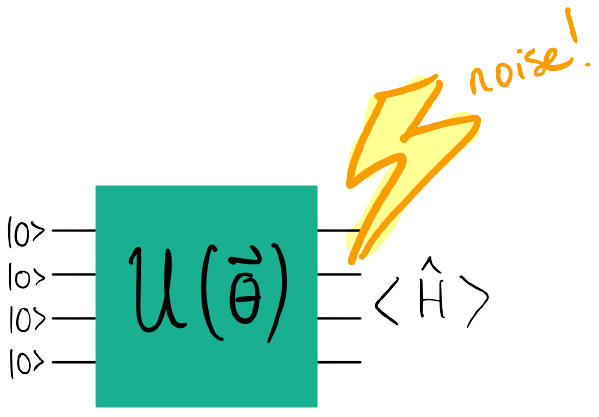">

The three error-ridden VQE routines must be constructed from a noisy device, where a depolarizing channel is present on _all_ gates. There, you will employ PennyLane's builtin global circuit folding protocol that can be implemented via transforming a noisy QNode: [`qml.transforms.fold_global`](https://docs.pennylane.ai/en/stable/code/api/pennylane.transforms.fold_global.html?highlight=qml.transforms.fold_global).


## Challenge code

The provided code below contains a few functions:
- `hydrogen_hamiltonian`: this function creates the Hamiltonian describing the H molecule given a hydrogen-to-hydrogen distance `d`.
- `ansatz_template`: this is a quantum function that defines the ansatz for all VQE routines that you will perform.
- `VQE`: this function performs a VQE routine given a QNode that you created with `qnode_ansatzes`.
- `qnode_ansatzes`: employs `ansatz_template` to create QNodes given different devices: an ideal device (no noise) and "mitigated" devices that are global-circuit-folding transformed devices. **You must complete this function**.
- `extrapolation`: this is where the magic happens; all VQE routines run, and then the zero-noise extrapolation takes place. **You must complete this function**.

The three error-ridden VQE routines that you perform are tied to three different _scale factors_. The scale factors define the global circuit folding procedure, and more information can be found in the documentation for [`qml.transforms.fold_global`](https://docs.pennylane.ai/en/stable/code/api/pennylane.transforms.fold_global.html?highlight=qml.transforms.fold_global). When you perform the extrapolation, you will be fitting a second-degree polynomial function (a quadratic function) to VQE energies versus scale factors.

### Input

As input to this problem, you will be given `d`, the hydrogen-to-hydrogen distance that defines its molecular Hamiltonian.

### Output

This code will output two energies corresponding to the noise-free VQE routine and the extrapolated energy from the ZNE routine: `[ideal_energy, zne_energy]` (`list(float)`).

If your solution matches the correct one within the given tolerance specified in `check` (in this case it's a `0.01` relative error tolerance), the output will be `"Correct!"`. Otherwise, you will receive a `"Wrong answer"` prompt.

Good luck!

In [ ]:
import functools
import json
import math
import pandas as pd
import pennylane as qml
import pennylane.numpy as np
import scipy

In [ ]:
def hydrogen_hamiltonian(d):
    """Creates the H_2 Hamiltonian from a separation distance.

    Args:
        d (float): The distance between a hydrogen atom and the hydrogen molecule's centre of mass.

    Returns:
        H (qml.Hamiltonian): The H_2 Hamiltonian.
        qubits (int): The number of qubits needed to simulate the H_2 Hamiltonian.
    """

    symbols = symbols = ["H", "H"]
    coordinates = np.array([0.0, 0.0, -d, 0.0, 0.0, d])
    H, qubits = qml.qchem.molecular_hamiltonian(symbols, coordinates)

    return H, qubits

def ansatz_template(param, wires):
    """The unitaries used for creating an ansatz for subsequent VQE calculations.

    Args:
        param (np.array): A single differentiable parameter
        wires (list(int)): A list of wires that the unitaries are applied to.
    """
    qml.BasisState([1, 1, 0, 0], wires=wires)
    qml.DoubleExcitation(param, wires=wires)

def VQE(qnode):
    """Performs a VQE routine given a QNode.

    Args:
        qnode (qml.QNode):
            The ansatz that will be optimized in order to find the ground state
            of molecular hydrogen.

    Retuns:
        final_energy (float): The final energy from the VQE routine.
    """
    param = np.array(0.0, requires_grad=True)
    num_iters = 20
    opt = qml.GradientDescentOptimizer(stepsize=0.4)

    for _ in range(num_iters):
        param = opt.step(qnode, param)

    final_energy = qnode(param)

    return final_energy


In [ ]:
def qnode_ansatzes(d, scale_factors):
    """Generates ideal and mitigated qnodes.

    Args:
        d (float): The distance between a hydrogen atom and the hydrogen molecule's centre of mass.
        scale_factors (list(int)): A list of scale factors used for ZNE.

    Returns:
       qnode_ideal (qml.QNode): The ideal QNode (no noise).
       qnodies_mitgated (list(qml.QNode)): A list of QNodes that are mitigated. len(qnodes_mitigated) = len(scale_factors).
    """
    H, qubits = hydrogen_hamiltonian(d)

    noise_gate = qml.DepolarizingChannel
    noise_strength = 0.05

    # Put your code here #

    dev_ideal = qml.device("default.mixed", wires=qubits)

    return qnode_ideal, qnodes_mitigated

def extrapolation(d, scale_factors, plot=False):
    """Performs ZNE to obtain a zero-noise estimate on the ground state energy of H_2.

    Args:
        d (float): The distance between a hydrogen atom and the hydrogen molecule's centre of mass.
        scale_factors (list(int)): A list of scale factors used for ZNE.

    Returns:
        ideal_energy (float): The ideal energy from a noise-less VQE routine.
        zne_energy (float): The zero-noise estimate of the ground state energy of H_2.

        These two energies are returned in that order within a numpy array.
    """

    qnode_ideal, qnodes_mitigated = qnode_ansatzes(d, scale_factors)

    ideal_energy = np.round_(VQE(qnode_ideal), decimals=6)
    mitigated_energies = [VQE(qnode) for qnode in qnodes_mitigated]

    # Put your code here #

    return np.array([ideal_energy, zne_energy]).tolist()


In [ ]:
# These functions are responsible for testing the solution.

def run(test_case_input: str) -> str:
    d = json.loads(test_case_input)
    scale_factors = [1, 2, 3]
    energies = extrapolation(d, scale_factors)
    return str(energies)


def check(solution_output: str, expected_output: str) -> None:
    solution_output = json.loads(solution_output)
    expected_output = json.loads(expected_output)
    assert np.allclose(
        solution_output, expected_output, rtol=1e-2
    ), "Your extrapolation isn't quite right!"


In [ ]:
test_cases = [['0.6614', '[-1.13619, -0.41168]']]

In [ ]:
for i, (input_, expected_output) in enumerate(test_cases):
    print(f"Running test case {i} with input '{input_}'...")

    try:
        output = run(input_)

    except Exception as exc:
        print(f"Runtime Error. {exc}")

    else:
        if message := check(output, expected_output):
            print(f"Wrong Answer. Have: '{output}'. Want: '{expected_output}'.")

        else:
            print("Correct!")